# **Preparation: Importing Libraries and Defining Work Directory**

In [2]:
## Importing Libraries

# JSON & OS
import json                   # read/write JSON files
import os                     # file‐path operations and directory listings

# Data handling
import pandas as pd           # tabular data structures (DataFrame)
import numpy as np            # numerical arrays and math routines

# Plotting
import matplotlib.pyplot as plt               # general 2D plotting
from matplotlib.colors import ListedColormap, BoundaryNorm
                                              # custom discrete colormaps and normalization
import matplotlib.gridspec as gridspec        # fine‐grained subplot layouts

# Geospatial & raster I/O
import geopandas as gpd                       # vector data (GeoDataFrame) handling
from shapely.geometry import Point, box       # construct point & polygon geometries
!pip install rasterio
import rasterio                               # raster file I/O (GeoTIFFs, etc.)
from rasterio.plot import show                # convenience wrapper for plt.imshow of rasters

# Machine learning & metrics
from sklearn.ensemble import RandomForestClassifier
                                              # random forest classifier
from sklearn.metrics import (
    average_precision_score,   # PR‐AUC
    precision_score,           # binary/multiclass precision
    recall_score,              # binary/multiclass recall
    f1_score,                  # F1 metric
    accuracy_score,            # overall accuracy
    classification_report,     # full precision/recall/F1 report
    confusion_matrix,          # confusion matrix
    precision_recall_curve,    # compute PR curve
    auc                        # area under curve
)

# Utilities
from itertools import product                   # Cartesian product for grid‐search loops
import re                                        # regular expressions (e.g. year‐in‐filename parsing)
from glob import glob                            # file‐pattern matching (e.g. “*.tif”)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.9 MB/s eta 0:00:00


In [3]:
# Mount your Google Drive and Defining the work directory
from google.colab import drive
drive.mount('/content/drive')


from glob import glob

# Work Directory
raster_dir = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images'

# get a sorted list of all .tif  files
raster_paths = sorted(glob(os.path.join(raster_dir, '*.tif')))

# check we have at least 15 from 2007 to 2021
assert len(raster_paths) >= 15, f'Found only {len(raster_paths)} rasters!'



rasters = []
for p in raster_paths:
    with rasterio.open(p) as src:
        rasters.append({
            'name': os.path.basename(p),
            'arr': src.read()   # shape = (bands, rows, cols)
        })


Mounted at /content/drive


# **Data Ingestion, Exploration and Processing**

## **a. Explore data shape**

In [4]:
rows = []
files = sorted(glob(os.path.join(raster_dir, '*.tif')))[:15]
for fp in files:
    with rasterio.open(fp) as src:
        # Read band 1 as a masked array so that src.nodata is masked
        band1 = src.read(1, masked=True)
        rows.append({
            'filename': os.path.basename(fp),
            'crs': src.crs.to_string(),
            'transform': tuple(src.transform),
            'shape (rows, cols)': band1.shape,
            'nodata value': src.nodata,
            'missing pixels': int(np.count_nonzero(band1.mask)),
            'unique classes': np.unique(band1.compressed()).tolist()
        })

# Show results
df = pd.DataFrame(rows)
print(df.to_string(index=False))

                filename        crs                                                   transform shape (rows, cols) nodata value  missing pixels                                                                                                                         unique classes
Emmet_landcover_2007.tif EPSG:32615 (56.0, 0.0, 344662.0, 0.0, -56.0, 4818266.0, 0.0, 0.0, 1.0)         (502, 692)         None               0                             [0, 1, 5, 23, 24, 28, 29, 36, 47, 63, 87, 111, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176, 190, 195]
Emmet_landcover_2008.tif EPSG:32615 (30.0, 0.0, 344625.0, 0.0, -30.0, 4818225.0, 0.0, 0.0, 1.0)        (936, 1292)         None               0                     [0, 1, 5, 12, 13, 23, 24, 27, 28, 29, 36, 37, 61, 111, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176, 190, 195]
Emmet_landcover_2009.tif EPSG:32615 (30.0, 0.0, 344625.0, 0.0, -30.0, 4818225.0, 0.0, 0.0, 1.0)        (936, 1292)         None               0                 [0,

**A simple Visualization**

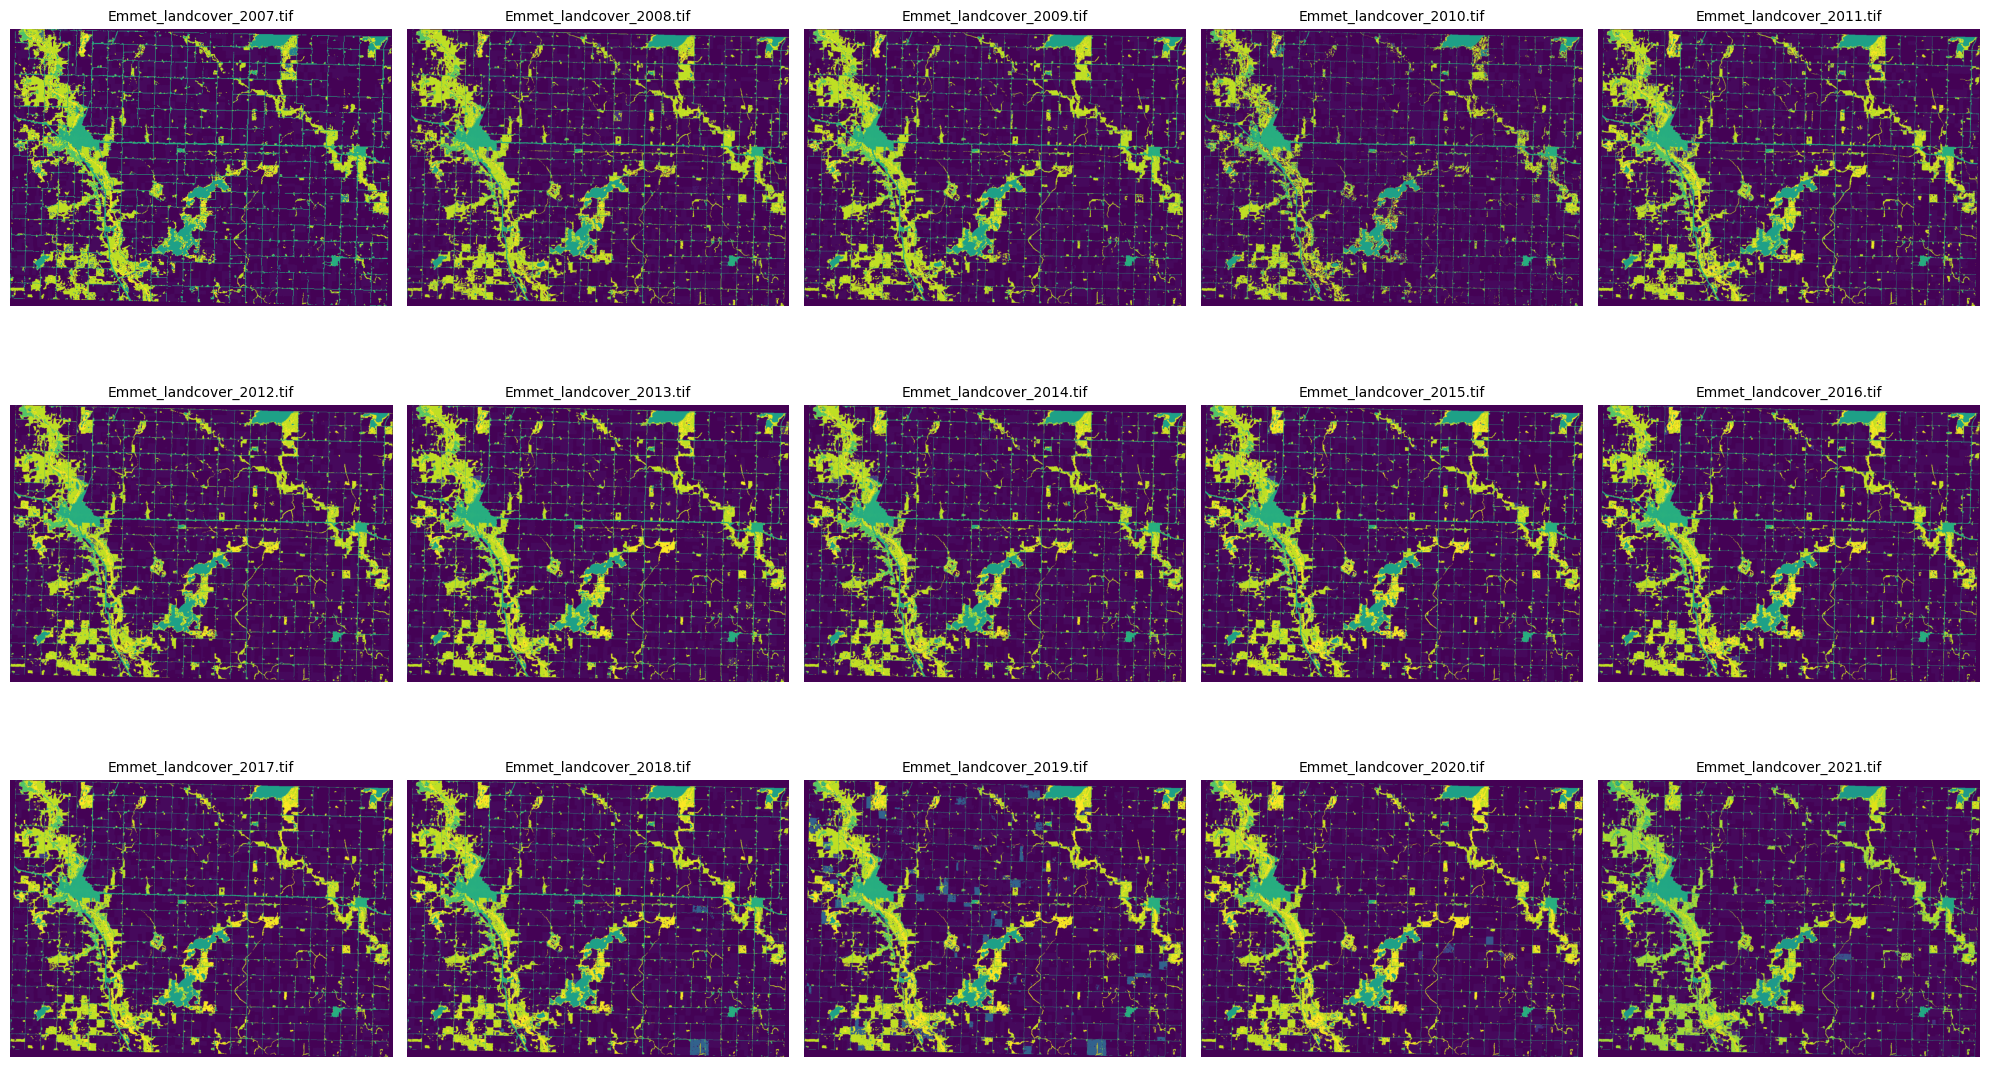

In [5]:
#  Plot in a 3×5 grid


fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, r in zip(axes, rasters):
    arr = r['arr']
    # If ≥3 bands, show an RGB composite; else just the first band
    if arr.shape[0] >= 3:
        rgb = arr[:3, :, :].transpose(1, 2, 0)
        ax.imshow(rgb)
    else:
        ax.imshow(arr[0, :, :])
    ax.set_title(r['name'], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **b. Reclassify into Consistent 3 Classes**

In [6]:
# Define directories
raster_dir = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images'
output_dir = os.path.join(raster_dir, 'reclassified')
os.makedirs(output_dir, exist_ok=True)

# List all .tif files to reclassify
raster_paths = sorted(glob(os.path.join(raster_dir, '*.tif')))

# Loop through each raster and apply reclassification
for src_path in raster_paths:
    with rasterio.open(src_path) as src:
        arr = src.read(1)
        meta = src.meta.copy()

    # Reclass: 1 -> 1, 5 -> 2, everything else -> 3
    reclass = np.where(arr == 1, 1, np.where(arr == 5, 2, 3)).astype(np.uint8)

    # Update metadata for single band uint8 output
    meta.update({
        'dtype': 'uint8',
        'count': 1,
        'nodata': None
    })

    # Construct output path
    fname = os.path.basename(src_path)
    out_path = os.path.join(output_dir, f'reclass_{fname}')

    # Write the reclassified raster
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(reclass, 1)

print(f'Reclassified rasters saved to: {output_dir}')


Reclassified rasters saved to: /content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified


## **c. Training Samples**
* A simple 10 by 10 grid mesh was used to insure spatial representative in every 10 hectares.
* 10% (120,931) of the total pixel count (936 × 1292) was selected as the representative sample. Training, validating and testing samples were split in 50:20:30 ratios.
* Class representativeness was checked for classes imbalance
* Primary these sample points will be used in the training, optimization and testing modele's performance.
* Additionally, a simplified exploration of the temporal land cover change pattern will be conducted using these samples.


**i. Generating Random Samples using Spatial rules**

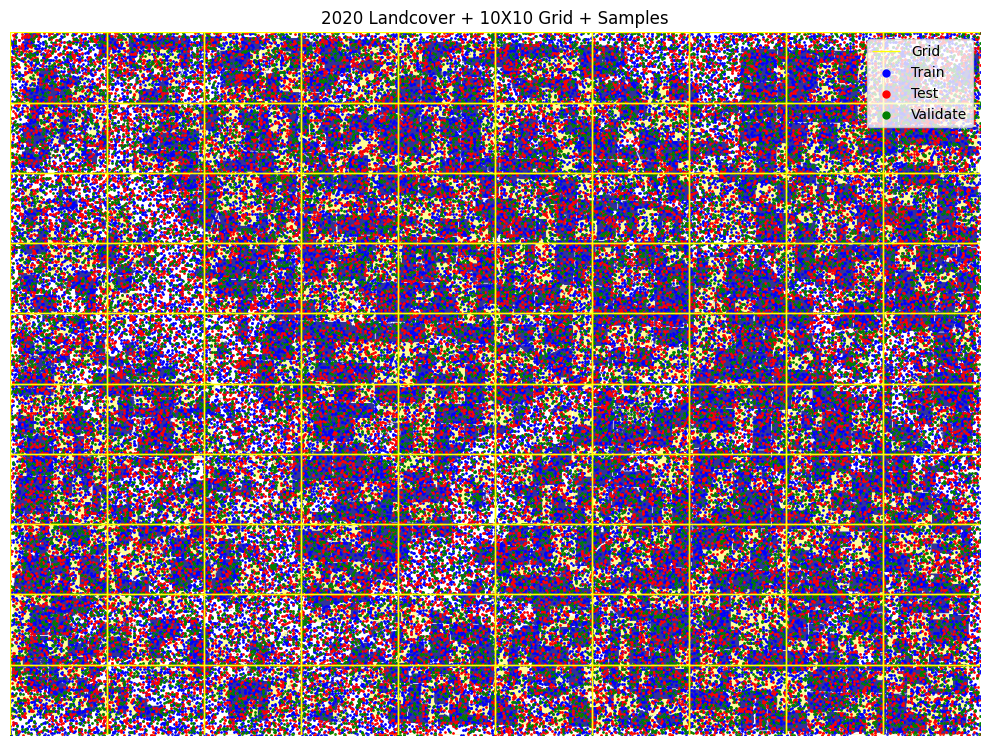

In [7]:
np.random.seed(42)

raster_dir = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified'
reclassified_paths = sorted(glob(os.path.join(raster_dir, '*.tif')))
assert len(reclassified_paths) >= 15

# 2. Read first raster for transform, CRS, bounds, size
from rasterio.transform import rowcol, xy

with rasterio.open(reclassified_paths[3]) as src:
    transform = src.transform
    crs       = src.crs
    left, bottom, right, top = src.bounds
    height, width = src.height, src.width

# 3. Build a 10×10 grid in map‐space from the bounds
n_rows, n_cols = 10, 10
x_edges = np.linspace(left,  right,  n_cols+1)
y_edges = np.linspace(bottom, top, n_rows+1)

grid_cells = []
pixel_cells = []  # will store (row0,row1,col0,col1) for each grid
for i in range(n_cols):
    for j in range(n_rows):
        minx, maxx = x_edges[i],   x_edges[i+1]
        miny, maxy = y_edges[j],   y_edges[j+1]
        # polygon for plotting
        grid_cells.append(box(minx, miny, maxx, maxy))
        # convert corner coords back to pixel rows/cols
        row0, col0 = rowcol(transform, minx, maxy)  # UL
        row1, col1 = rowcol(transform, maxx, miny)  # LR
        # clamp into [0,height],[0,width]
        row0, row1 = np.clip([row0, row1], 0, height-1)
        col0, col1 = np.clip([col0, col1], 0, width-1)
        pixel_cells.append((min(row0,row1), max(row0,row1),
                            min(col0,col1), max(col0,col1)))

gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs=crs)

# 4. Define overall totals & ratios
total_samples = 120930 #10% of the total pixel count
train_frac    = 0.50
val_frac      = 0.20
test_frac     = 0.30

train_total = int(total_samples * train_frac)
val_total   = int(total_samples * val_frac)
test_total  = total_samples - train_total - val_total

n_cells = len(pixel_cells)

def distribute(n_total):
    base = n_total // n_cells
    rem  = n_total %  n_cells
    return [base + (1 if i<rem else 0) for i in range(n_cells)]

train_counts = distribute(train_total)
val_counts   = distribute(val_total)
test_counts  = distribute(test_total)

# 5. Sample points per cell
train_pts, val_pts, test_pts = [], [], []

for (r0, r1, c0, c1), nt, nv, nte in zip(pixel_cells, train_counts, val_counts, test_counts):
    # sample rows/cols for each split
    rows_tr = np.random.randint(r0, r1+1, size=nt)
    cols_tr = np.random.randint(c0, c1+1, size=nt)

    rows_val = np.random.randint(r0, r1+1, size=nv)
    cols_val = np.random.randint(c0, c1+1, size=nv)

    rows_te = np.random.randint(r0, r1+1, size=nte)
    cols_te = np.random.randint(c0, c1+1, size=nte)

    # map to coordinates
    xs_tr, ys_tr = xy(transform, rows_tr, cols_tr, offset='center')
    xs_val, ys_val = xy(transform, rows_val, cols_val, offset='center')
    xs_te, ys_te = xy(transform, rows_te, cols_te, offset='center')

    train_pts += [Point(x, y) for x,y in zip(xs_tr, ys_tr)]
    val_pts   += [Point(x, y) for x,y in zip(xs_val, ys_val)]
    test_pts  += [Point(x, y) for x,y in zip(xs_te, ys_te)]

# 6. Build GeoDataFrames
gdf_train = gpd.GeoDataFrame(geometry=train_pts, crs=crs)
gdf_val   = gpd.GeoDataFrame(geometry=val_pts,   crs=crs)
gdf_test  = gpd.GeoDataFrame(geometry=test_pts,  crs=crs)

# 8. Plot 2020 image with grid + samples
# Take the as an example file for visual purposes
path2020 = next(f for f in reclassified_paths if f.endswith('_2020.tif'))
with rasterio.open(path2020) as src20:
    img20 = src20.read(1)
    tr20  = src20.transform

fig, ax = plt.subplots(1,1, figsize=(10,10))
show(img20, transform=tr20, cmap='terrain', ax=ax)
gdf_grid.boundary.plot(ax=ax, edgecolor='yellow', linewidth=1, label='Grid')
gdf_train.plot(ax=ax, markersize=1, color='blue', label='Train')
gdf_test .plot(ax=ax, markersize=1, color='red',  label='Test')
gdf_val.plot(ax=ax, markersize=1, color='green', label='Validate')
ax.legend(loc='upper right', markerscale=5)
ax.set_title('2020 Landcover + 10X10 Grid + Samples')
ax.set_axis_off()
plt.tight_layout()
plt.show()


**ii. Checking Sample imbalance using target classification of 2021**

In [8]:

# 1. **Manually** set your 2020 filename here:
path2021 = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified/reclass_Emmet_landcover_2021.tif'

# 2. Open and read
with rasterio.open(path2021) as src:
    lc = src.read(1)
    nodata = src.nodata
    transform = src.transform

# 3. Sample the raster at each train/test point
train_coords = [(pt.x, pt.y) for pt in gdf_train.geometry]
val_coords  = [(pt.x, pt.y) for pt in gdf_val.geometry]
test_coords  = [(pt.x, pt.y) for pt in gdf_test.geometry]

with rasterio.open(path2021) as src:
    train_vals = [v[0] for v in src.sample(train_coords)]
    val_vals = [v[0] for v in src.sample(val_coords)]
    test_vals  = [v[0] for v in src.sample(test_coords)]

# 4. Attach class labels
gdf_train['class'] = train_vals
gdf_val['class'] = val_vals
gdf_test ['class'] = test_vals

# 5. Count per class
train_counts = gdf_train['class'].value_counts().sort_index()
val_counts = gdf_val['class'].value_counts().sort_index()
test_counts  = gdf_test ['class'].value_counts().sort_index()

# Compute percentages
train_pct = train_counts / train_counts.sum() * 100
val_pct = val_counts / val_counts.sum() * 100
test_pct  = test_counts  / test_counts.sum()  * 100

# Print them
for cls in sorted(train_pct.index):
    t_pct = train_pct.get(cls, 0)
    v_pct = val_pct.get(cls,  0)
    e_pct = test_pct.get(cls,  0)
    print(f"Class {cls}:  train {t_pct:.2f}% ,  Validation {v_pct:.2f}% ,  test {e_pct:.2f}%")


Class 1:  train 40.49% ,  Validation 40.62% ,  test 39.85%
Class 2:  train 33.88% ,  Validation 33.40% ,  test 34.11%
Class 3:  train 25.63% ,  Validation 25.98% ,  test 26.05%


## **d. Extracting Values per pixels**

In [9]:
raster_dir = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified'
raster_paths = sorted(glob(os.path.join(raster_dir, '*.tif')))

# 2. Map each year to the first file that contains that year in its name
years = list(range(2008, 2022))
raster_files = {}
for year in years:
    candidates = [p for p in raster_paths if f"{year}" in os.path.basename(p)]
    if not candidates:
        raise FileNotFoundError(f"No raster found containing '{year}' in its filename")
    raster_files[year] = candidates[0]  # picks the first match

# 3. Function to extract values for a GeoDataFrame of points
def extract_values(df):
    coords = [(pt.x, pt.y) for pt in df.geometry]
    data = pd.DataFrame({'x': [x for x, y in coords],
                         'y': [y for x, y in coords]})
    for year in years:
        with rasterio.open(raster_files[year]) as src:
            vals = [v[0] for v in src.sample(coords)]
        data[f'value_{year}'] = vals
    if 'class' in df.columns:
        data['class'] = df['class'].values
    return data

# 4. Build and preview the training and testing DataFrames
train_df = extract_values(gdf_train)
val_df  = extract_values(gdf_val)
test_df  = extract_values(gdf_test)


In [10]:
# 5. Define feature columns and target
features = [f'value_{year}' for year in range(2008, 2021)]
target   = 'value_2021'

# 6. Split into X/y for train and test
X_train = train_df[features]
X_train_df=X_train.copy()
y_train = train_df[target]

X_val  = val_df[features]
X_val_df=X_val.copy()
y_val  = val_df[target]

X_test  = test_df[features]
X_test_df=X_test.copy()
y_test  = test_df[target]

# **3. Modelling and Evaluation**

## **Method 2: A simple probability based prediction**

A simple probability model is designed with simple assumptions;
- **Land cover changes follow historical transition patterns**: Future land cover (2021) depends on past years.  
- **A range years are more informative than others**: The best range of past years could vary based on data trends.  
- **The highest probability rule still applies**: Once the best year range is identified, we use the highest probability method for classification.  


For that case in this section we:


- **Compute Transition Probabilities**  
  - Group data by past land cover classes.  
  - Count occurrences of each `value_2021` class.  
  - Normalize counts to compute probabilities (`P(Class_1)`, `P(Class_2)`, `P(Class_3)`).  

- **Iterate between different sizes of historical dataset**  
  - Evaluate performance using **cross-validation** to measure accuracy.
  - Select the **top-performing sequence** based on validation results.

- **Apply the Best Year Combination to Probability-Based Prediction**  
  - Use the **best-selected years** to compute transition probabilities.
  - Follow the **maximum probability classification rule** to assign predictions.

- **Apply the Rule to the Test Set**  
  - Merge predictions with test data (`X_test` and `y_test`).  
  - Compare predicted classes with actual classes (`Actual_Class`).  

- **Evaluate Performance**  
  - Compute **accuracy** by checking overall predictions.  
  - Generate **confusion matrix** to analyze misclassifications.  
  - Calculate **precision & recall** to assess class-wise prediction quality.
    - Calculate **Adding PR-AUC** to compare the performance of different models.  


### **Important Functions**

* Building the history → P(class) frequency table

* Looking up probabilities for a set of histories (on val/test or on every pixel)

* Argmax → hard predictions → evaluate

### **a. Validate the best historical combination for the probability theory**

In [11]:
# 1) Prepare
classes = sorted(np.unique(y_train))
K       = len(classes)

# years = 2008..2020 → features length = 13
all_years = list(range(2008, 2021))
max_k     = len(all_years)  # 13

results = []

for k in range(1, max_k+1):
    hist_years = all_years[-k:]
    hist_cols  = [f'value_{y}' for y in hist_years]

    # Build the frequency table on TRAIN
    dfh = train_df[hist_cols + ['value_2021']]
    counts = (
        dfh
        .groupby(hist_cols)['value_2021']
        .value_counts()
        .unstack(fill_value=0)
    )
    probs = counts.div(counts.sum(axis=1), axis=0)

    # 2) Score on VAL
    Xh     = val_df[hist_cols]
    y_true = val_df['value_2021'].to_numpy()

    P = np.zeros((len(Xh), K))
    for i, hist in enumerate(map(tuple, Xh.values)):
        if hist in probs.index:
            row = probs.loc[hist].reindex(classes, fill_value=0).to_numpy()
        else:
            row = np.ones(K) / K
        P[i] = row

    # 3) compute PR-AUC for each class
    for j, c in enumerate(classes):
        mask     = (y_true == c).astype(int)
        precision, recall, _ = precision_recall_curve(mask, P[:, j])
        pr_auc   = auc(recall, precision)
        results.append({
            'history_length': k,
            'class':          c,
            'pr_auc':         pr_auc
        })

# 4) tabulate and pivot
df_pr = pd.DataFrame(results)
# Pivot so each history_length is a row, classes are columns
df_hist = df_pr.pivot(
    index='history_length',
    columns='class',
    values='pr_auc'
)

# Compute mean PR‐AUC over classes 1 & 2
df_hist['mean_pr_auc_1_2'] = df_hist[[1, 2]].mean(axis=1)

# Find the best history length
best_k    = df_hist['mean_pr_auc_1_2'].idxmax()
best_score = df_hist.loc[best_k, 'mean_pr_auc_1_2']

print(f"Best history length by mean PR-AUC (classes 1&2): {best_k} years (mean PR-AUC={best_score:.3f})")



Best history length by mean PR-AUC (classes 1&2): 13 years (mean PR-AUC=0.998)


### **Checking the performance**

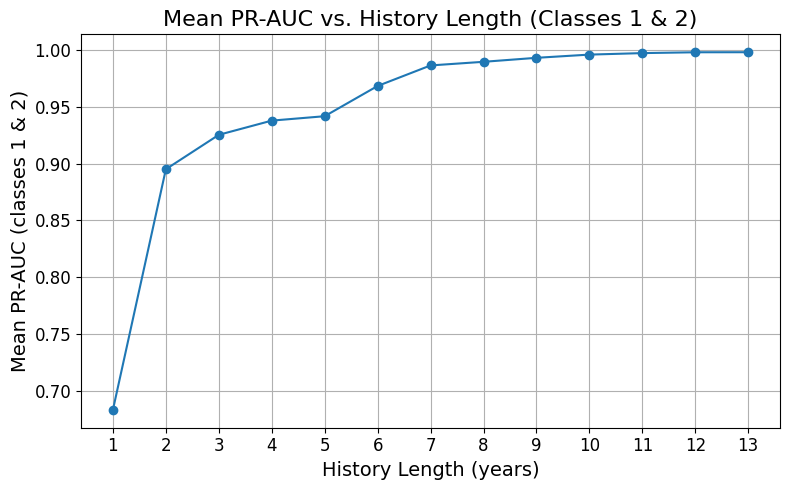

In [12]:
# only keep class 1 & 2
df_sub = df_pr[df_pr['class'].isin([1, 2])]

# compute mean PR-AUC over those two classes (Corn and Soy Beans)
df_mean12 = (
    df_sub
      .groupby('history_length')['pr_auc']
      .mean()
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_mean12['history_length'], df_mean12['pr_auc'], marker='o')

ax.set_xlabel('History Length (years)', fontsize=14)
ax.set_ylabel('Mean PR-AUC (classes 1 & 2)', fontsize=14)
ax.set_title('Mean PR-AUC vs. History Length (Classes 1 & 2)', fontsize=16)

ax.set_xticks(df_mean12['history_length'])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.grid(True)
plt.tight_layout()
plt.show()


### **b. Testing Model Performance on Unseen Data**

In [13]:
# 1. Select history data of the selected best output (the last‐7 years (2013–2020))
all_years = list(range(2008, 2021))
hist_years = all_years[-4:]              # [2013,...,2020]
hist_cols  = [f'value_{y}' for y in hist_years]

# 2. Rebuild the frequency model using only those 4 features
dfh    = train_df[hist_cols + ['value_2021']]
counts = dfh.groupby(hist_cols)['value_2021'] \
            .value_counts() \
            .unstack(fill_value=0)
probs  = counts.div(counts.sum(axis=1), axis=0)

# 3. Predict on TEST by lookup (fallback to uniform)
Xh_test    = test_df[hist_cols]
y_true     = test_df['value_2021'].to_numpy()
classes    = sorted(train_df['value_2021'].unique())
pred_probs = np.zeros((len(Xh_test), len(classes)))

for i, hist in enumerate(map(tuple, Xh_test.values)):
    if hist in probs.index:
        row = probs.loc[hist].reindex(classes, fill_value=0).to_numpy()
    else:
        row = np.ones(len(classes)) / len(classes)
    pred_probs[i] = row

pred_idx    = np.argmax(pred_probs, axis=1)
pred_labels = np.array(classes)[pred_idx]

# 4. Evaluate performance
acc = accuracy_score(y_true, pred_labels)
print(f"Test Accuracy (last‐4‐year freq model): {acc:.5f}\n")
print("Classification Report:")
print(classification_report(y_true, pred_labels, digits=5))
print("Confusion Matrix:")
print(confusion_matrix(y_true, pred_labels))

# 5. Export corn & soybeans performance to JSON for method2
label_map = {1: "corn", 2: "soybeans"}
perf2 = {}

for cls, crop in label_map.items():
    y_true_bin = (y_true == cls).astype(int)
    y_pred_bin = (pred_labels == cls).astype(int)
    perf2[crop] = {
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall":    recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1_score":  f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

with open("prediction_performance_corn_soybeans_method2.json", "w") as f:
    json.dump(perf2, f, indent=2)

print("\n Exported Method 2 performance to prediction_performance_corn_soybeans_method2.json")

Test Accuracy (last‐4‐year freq model): 0.91993

Classification Report:
              precision    recall  f1-score   support

           1    0.88486   0.92662   0.90526     14282
           2    0.90616   0.86125   0.88313     12288
           3    0.99098   0.98434   0.98765      9709

    accuracy                        0.91993     36279
   macro avg    0.92733   0.92407   0.92535     36279
weighted avg    0.92047   0.91993   0.91981     36279

Confusion Matrix:
[[13234  1003    45]
 [ 1663 10583    42]
 [   59    93  9557]]

 Exported Method 2 performance to prediction_performance_corn_soybeans_method2.json


### **c. Classify the Image**

In [14]:
# 1. Point this at wherever you have your reclass_*.tif files
base_dir   = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images'
search_dirs = [raster_dir]


# 2. Gather all candidate rasters and pick out years 2008–2020
years = list(range(2008, 2021))
tifs  = []
for d in search_dirs:
    tifs += glob(os.path.join(d, 'reclass_*.tif'))

year_to_file = {}
for p in tifs:
    m = re.search(r'(\d{4})', os.path.basename(p))
    if m:
        y = int(m.group(1))
        if y in years:
            year_to_file[y] = p

# sanity check
missing = [y for y in years if y not in year_to_file]
if missing:
    raise FileNotFoundError(f"Missing reclassified rasters for years: {missing}")

# 3. Re-build the 13-year frequency model from train_df
hist_cols = [f'value_{y}' for y in years]
classes   = sorted(train_df['value_2021'].unique())

dfh    = train_df[hist_cols + ['value_2021']]
counts = dfh.groupby(hist_cols)['value_2021'].value_counts().unstack(fill_value=0)
probs  = counts.div(counts.sum(axis=1), axis=0)

# 4. Read & stack the rasters into a (H,W,13) array
paths = [year_to_file[y] for y in years]
with rasterio.open(paths[0]) as src0:
    meta      = src0.meta.copy()
    H, W      = src0.height, src0.width
    transform = src0.transform
    nodata    = src0.nodata

stack = np.stack([rasterio.open(p).read(1) for p in paths], axis=2)
mask  = np.any(stack == nodata, axis=2) if nodata is not None else np.zeros((H,W),bool)

# 5. Flatten → lookup → predict
flat       = stack.reshape(-1, len(years))
pred_probs = np.zeros((flat.shape[0], len(classes)))
for i, hist in enumerate(map(tuple, flat)):
    if hist in probs.index:
        row = probs.loc[hist].reindex(classes, fill_value=0).to_numpy()
    else:
        row = np.ones(len(classes)) / len(classes)
    pred_probs[i] = row

pred_idx  = np.argmax(pred_probs, axis=1)
pred_map  = np.array(classes)[pred_idx].reshape(H, W)
pred_map[mask] = nodata or 0




### **Display the results**

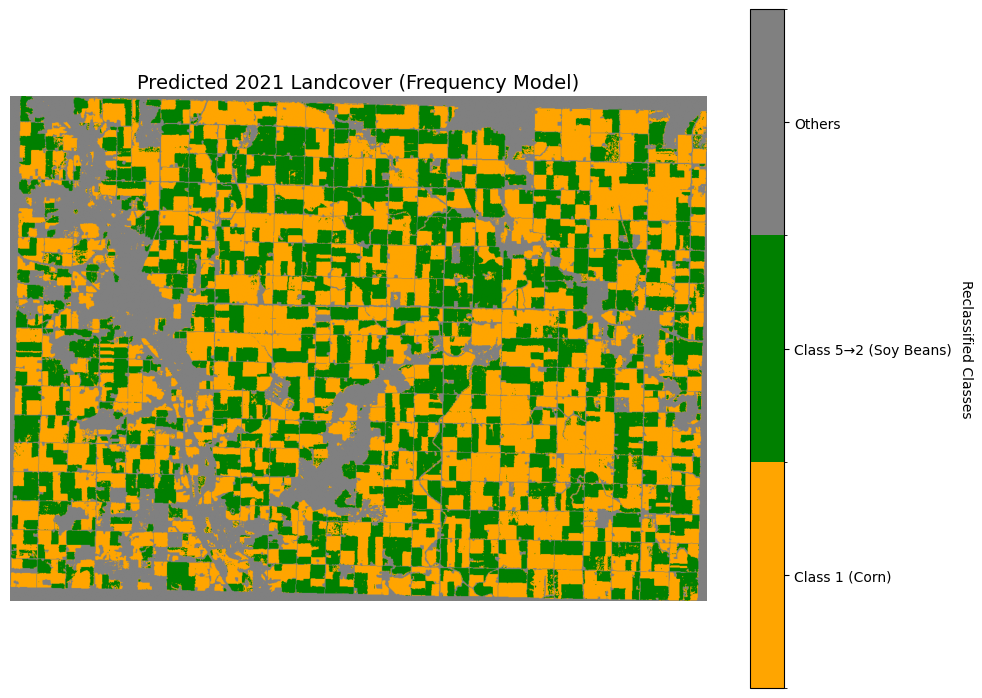

In [15]:
# 7. Visualize with your orange/green/gray legend
cmap = ListedColormap(['orange','green','gray'])
norm = BoundaryNorm([0.5,1.5,2.5,3.5], ncolors=cmap.N)

fig, ax = plt.subplots(figsize=(10,10))
show(pred_map, transform=transform, ax=ax, cmap=cmap, norm=norm)
ax.set_title('Predicted 2021 Landcover (Frequency Model)', fontsize=14)
ax.axis('off')

cbar = fig.colorbar(ax.images[0], ax=ax, ticks=[1,2,3], shrink=0.7)
cbar.ax.set_yticklabels([
    'Class 1 (Corn)',
    'Class 5→2 (Soy Beans)',
    'Others'
])
cbar.set_label('Reclassified Classes', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()


### **e. Save the Output Image**

In [16]:
# 6. Save as GeoTIFF
out_path = os.path.join(base_dir, 'prediction_Emmet_2021_corn_soybeans_method2.tif')
meta.update(dtype=rasterio.uint8, count=1, nodata=(nodata or 0))
with rasterio.open(out_path, 'w', **meta) as dst:
    dst.write(pred_map.astype(np.uint8), 1)
print("Saved prediction to:", out_path)


Saved prediction to: /content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/prediction_Emmet_2021_corn_soybeans_method2.tif


## **Method 1: Random Forest Classifier**

* Feature Selection & Training
Used past land cover values as features, predicting value_2021.
Conducted a grid search to optimize max_depth and class_weight specifically to address overfitting and class imbalances, respectively.
* Model Evaluation & Selection
Tested multiple Random Forest models on validation data.
Selected the best model based on Precision-Recall AUC (PR-AUC).
* Final Testing & Prediction
Applied the best-trained model to the test set and evaluated accuracy.
Used the trained model to classify every pixel for the 2021 land cover.


### **Training**

In [17]:
# Features & target
features = [f'value_{year}' for year in range(2008, 2021)]
X_train, y_train = train_df[features], train_df['value_2021']
X_val,   y_val   = val_df [features], val_df ['value_2021']

# Parameter grid: max_depth now 1 through 20
param_grid = {
    'max_depth': list(range(1, 21)),
    'class_weight': [None, 'balanced', {1:2, 2:1}, {1:1, 2:2}]
}

results = []
model_dict = {}
model_idx = 1

for max_depth, cw in product(param_grid['max_depth'], param_grid['class_weight']):
    model_name = f"rf_{model_idx}"
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        class_weight=cw,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    model_dict[model_name] = clf

    y_pred = clf.predict(X_val)
    for cls in [1, 2]:
        y_true = (y_val == cls)
        y_pred_bin = (y_pred == cls)
        results.append({
            'model_name': model_name,
            'max_depth': max_depth,
            'class_weight': str(cw),
            'class': cls,
            'precision': precision_score(y_true, y_pred_bin, zero_division=0),
            'recall':    recall_score(y_true, y_pred_bin, zero_division=0),
            'f1_score':  f1_score(y_true, y_pred_bin, zero_division=0)
        })
    model_idx += 1

df_results = pd.DataFrame(results)

### **Validation of the Model Accuracy**

In [18]:
# 1. Setup
features = [f'value_{year}' for year in range(2008, 2021)]
X_val, y_val = val_df[features], val_df['value_2021']
classes = sorted(y_val.unique())

# 2. Compute PR-AUC for each model & class
rows = []
for name, clf in model_dict.items():
    # get probability estimates for each class
    proba = clf.predict_proba(X_val)
    # sklearn returns columns in the order of clf.classes_
    for cls in classes:
        idx = list(clf.classes_).index(cls)
        y_true = (y_val == cls).astype(int)
        y_score = proba[:, idx]
        pr_auc = average_precision_score(y_true, y_score)
        rows.append({
            'model_name': name,
            'class': cls,
            'pr_auc': pr_auc
        })

# 3. Build a DataFrame and pivot for easy comparison
df_pr = pd.DataFrame(rows)

# 4. Show top model
df_pivot = df_pr.pivot(index='model_name', columns='class', values='pr_auc')
df_pivot['mean_pr_auc_1_2'] = df_pivot[[1, 2]].mean(axis=1)

best_model = df_pivot['mean_pr_auc_1_2'].idxmax()
best_value = df_pivot.loc[best_model, 'mean_pr_auc_1_2']

print(f"Best model by mean PR-AUC of classes 1&2: {best_model} ({best_value:.3f})")

Best model by mean PR-AUC of classes 1&2: rf_65 (1.000)


### **Testing and evaluation**

In [19]:

# 1. Get your best model
best_name = 'rf_65'
clf = model_dict[best_name]

# 1a. Print out the key hyperparameters
params = clf.get_params()
print(f"=== Model Parameters for {best_name} ===")
print(f"n_estimators : {params['n_estimators']}")
print(f"max_depth    : {params['max_depth']}")
print(f"class_weight : {params['class_weight']}")
print(f"random_state : {params['random_state']}\n")

# 2. Define features and test set
features = [f'value_{year}' for year in range(2008, 2021)]
X_test = test_df[features]
y_test = test_df['value_2021']

# 3. Make predictions
y_pred = clf.predict(X_test)

# 4. Print accuracy, classification report and confusion matrix
acc = accuracy_score(y_test, y_pred)
print(f"=== Performance Report for {best_name} ===\n")
print(f"Accuracy: {acc:.5f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=5))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 5. Show feature importances rounded to 5 decimals
fi = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
fi = fi.round(5)
print("\n=== Feature Importances (5 d.p.) ===")
print(fi.to_string())

# 6. Export corn & soybeans performance to JSON
label_map = {1: "corn", 2: "soybeans"}
perf1 = {}
for cls, crop in label_map.items():
    y_true_bin = (y_test == cls).astype(int)
    y_pred_bin = (y_pred == cls).astype(int)
    perf1[crop] = {
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall":    recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1_score":  f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

with open("prediction_performance_corn_soybeans_method1.json", "w") as f:
    json.dump(perf1, f, indent=2)

print("\n Exported Method 1 performance to prediction_performance_corn_soybeans_method1.json")


=== Model Parameters for rf_65 ===
n_estimators : 100
max_depth    : 17
class_weight : None
random_state : 42

=== Performance Report for rf_65 ===

Accuracy: 0.99639

Classification Report:
              precision    recall  f1-score   support

           1    0.99553   0.99706   0.99629     14282
           2    0.99569   0.99536   0.99552     12288
           3    0.99856   0.99670   0.99763      9709

    accuracy                        0.99639     36279
   macro avg    0.99659   0.99637   0.99648     36279
weighted avg    0.99639   0.99639   0.99639     36279

Confusion Matrix:
[[14240    38     4]
 [   47 12231    10]
 [   17    15  9677]]

=== Feature Importances (5 d.p.) ===
value_2015    0.22737
value_2017    0.17210
value_2018    0.12708
value_2016    0.10860
value_2014    0.10425
value_2013    0.06145
value_2012    0.05254
value_2019    0.04376
value_2020    0.03473
value_2011    0.02356
value_2009    0.01581
value_2010    0.01525
value_2008    0.01349

 Exported Method 1 pe

### **Classify the whole image**

In [20]:
# --- 5) Apply the same model to the full 13-year raster stack ---

# a. Retrieve the best model
best_model_by_mean_auc = model_dict['rf_61']

# b. Stack your reclassified rasters
years = list(range(2008, 2021))
raster_dir = '/content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified'
paths = [os.path.join(raster_dir, f'reclass_Emmet_landcover_{y}.tif') for y in years]

with rasterio.open(paths[0]) as src0:
    meta    = src0.meta.copy()
    height, width = src0.height, src0.width
    transform = src0.transform

stack = np.stack([rasterio.open(p).read(1) for p in paths], axis=2)

# c. Make nodata mask and prepare flat feature matrix
nodata_val = 0                       # choose 0 as your nodata
mask = np.any(stack == nodata_val, axis=2)

flat = stack.reshape(-1, len(years))
# Fill masked rows with 0 (won't matter, we'll re-mask later)
flat[mask.ravel(), :] = 0

# Wrap in DataFrame to preserve feature names and silence warnings
feature_names = [f'value_{y}' for y in years]
flat_df = pd.DataFrame(flat, columns=feature_names)

# d. Predict
pred_flat = best_model_by_mean_auc.predict(flat_df)
pred = pred_flat.reshape(height, width)
pred[mask] = nodata_val


# e. Save the result
out_path = os.path.join(raster_dir, 'prediction_Emmet_2021_corn_soybeans_method1.tif')
meta.update(dtype=rasterio.uint8, count=1, nodata=nodata_val)
with rasterio.open(out_path, 'w', **meta) as dst:
    dst.write(pred.astype(np.uint8), 1)

print("Saved to:", out_path)


Saved to: /content/drive/MyDrive/Job Applications/Hydrosat_Dan/Hydrosat Technical Challenge/images/reclassified/prediction_Emmet_2021_corn_soybeans_method1.tif


### **Visualize**

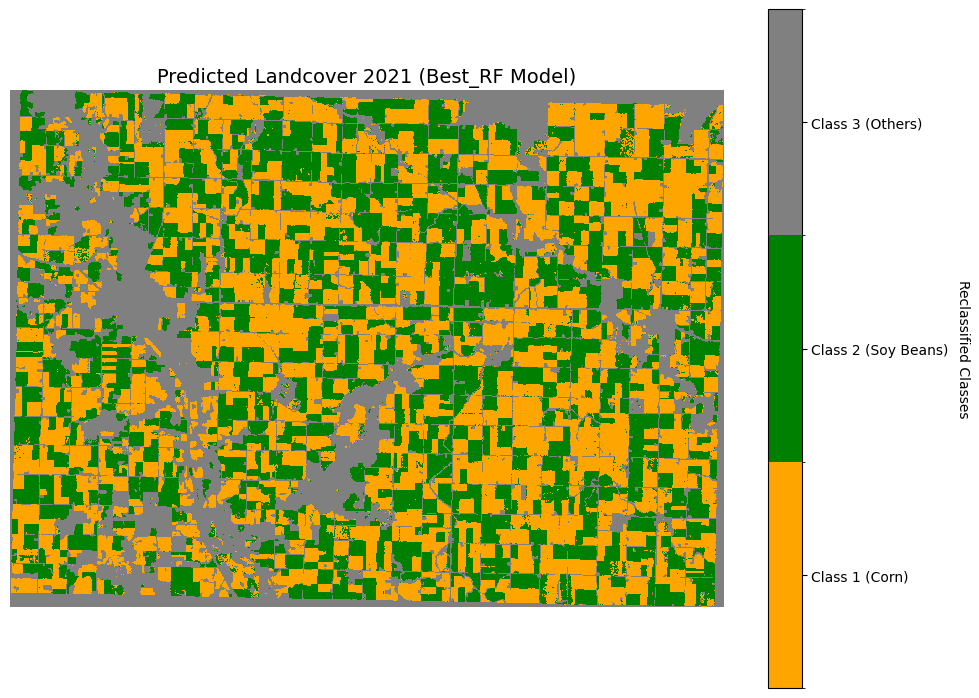

In [21]:

# Define custom colormap: 1=orange, 2=green, 3=gray
cmap = ListedColormap(['orange', 'green', 'gray'])
norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], ncolors=cmap.N)

# Plot the prediction
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pred, cmap=cmap, norm=norm, interpolation='nearest')
ax.set_title('Predicted Landcover 2021 (Best_RF Model)', fontsize=14)
ax.axis('off')

# Colorbar legend with labels
cbar = fig.colorbar(im, ax=ax, ticks=[1, 2, 3], shrink=0.7)
cbar.ax.set_yticklabels(['Class 1 (Corn)', 'Class 2 (Soy Beans)', 'Class 3 (Others)'])
cbar.set_label('Reclassified Classes', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# **Visual inspection of the three images**

<ipython-input-22-677164f824f9>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


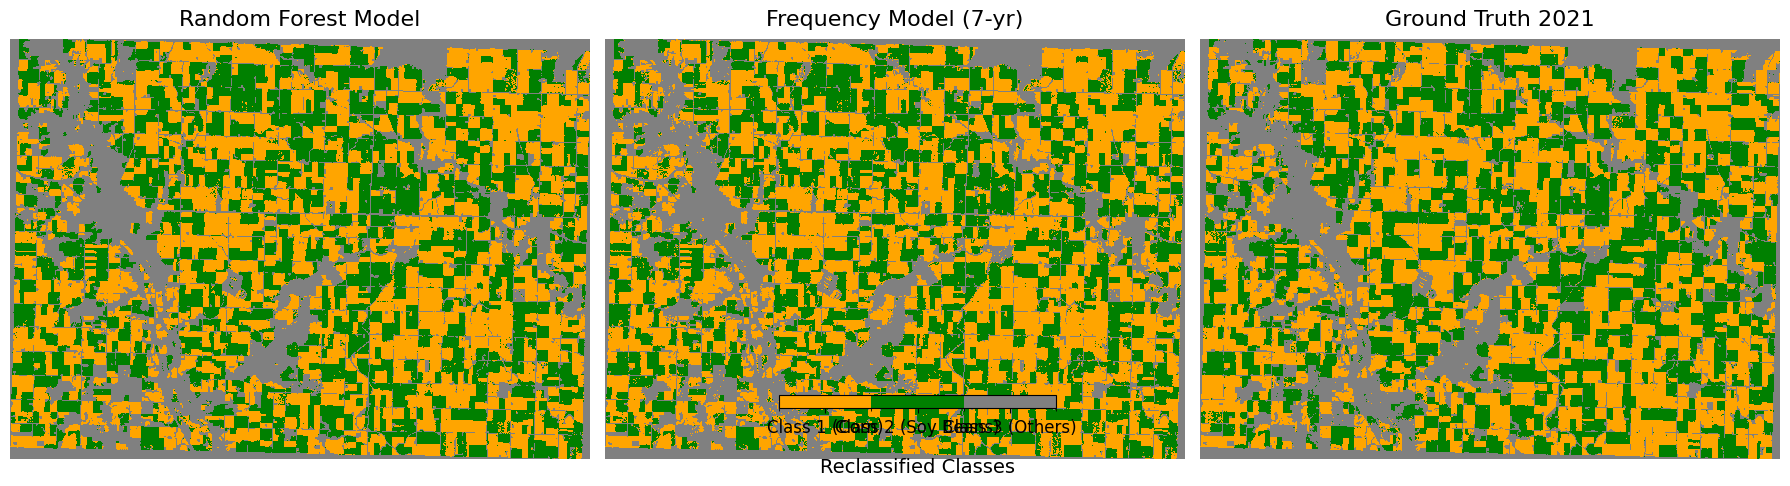

In [22]:
# 1) Load the ground truth
with rasterio.open(path2021) as src:
    gt = src.read(1)

# 2) Define the shared colormap & norm
cmap = ListedColormap(['orange','green','gray'])
norm = BoundaryNorm([0.5,1.5,2.5,3.5], ncolors=cmap.N)

# 3) Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

titles = [
    "Random Forest Model",
    "Frequency Model (7-yr)",
    "Ground Truth 2021"
]
arrays = [pred, pred_map, gt]

for ax, arr, title in zip(axes, arrays, titles):
    im = ax.imshow(arr, cmap=cmap, norm=norm, interpolation='nearest')
    ax.set_title(title, fontsize=16, pad=10)
    ax.axis('off')

# 4) Shared colorbar at bottom
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation='horizontal',
    fraction=0.03,   # make it a bit thinner
    pad=0.18,        # push it farther away from the plots
    ticks=[1,2,3]
)
cbar.ax.set_xticklabels([
    'Class 1 (Corn)',
    'Class 2 (Soy Beans)',
    'Class 3 (Others)'
], fontsize=12)
cbar.set_label('Reclassified Classes', fontsize=14, labelpad=15)


plt.tight_layout()
plt.show()
